## Tensors Dataset

In [253]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset
from PIL import Image, ImageFilter
import random

In [2]:
import matplotlib.pyplot as plt
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

In [3]:
cwd = os.getcwd()

In [228]:
y_data = np.load(cwd+'/all_classes.npy', allow_pickle=True)
X_data = np.load(cwd+'/all_cells_reclassified.npy', allow_pickle=True)

# list1 = np.load('sagemaker_pic_array.npy')

In [229]:
len(X_data)

67102

In [68]:
y_data[10:30]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [70]:
type(y_data[0])

numpy.float64

In [182]:
images = []
for i in range(len(X_data)):
    new_img = np.reshape(X_data[i], (28,28))
    images.append(new_img)

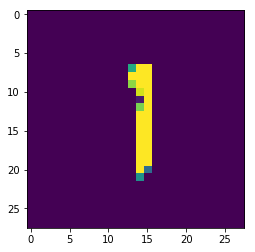

In [183]:
for i in range(1, 100):
    plt.imshow(images[i])

In [188]:
def merge(list1, list2): 
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
    return merged_list 
      


In [192]:
# image, label = next(iter(train_loader))
# helper.imshow(image[0,:]);

In [231]:
resize = []
for images in range(len(X_data)):
    X = np.reshape(X_data[images], (28,28))
    resize.append(X)

In [109]:
# dataset = merge(resize, y_data)

In [232]:
from PIL import Image
PIL_images = []
for i in range(len(resize)):
    PIL_image = Image.fromarray(resize[i])
    PIL_images.append(PIL_image)

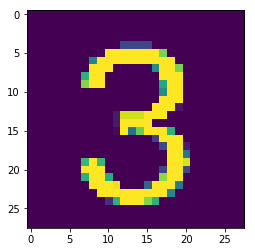

In [233]:
plt.imshow(PIL_images[20000])

In [240]:
dataset = merge(PIL_images, y_data)

In [261]:
random.shuffle(dataset)

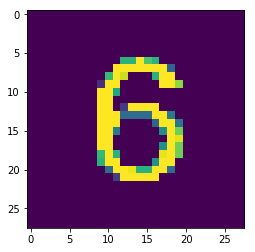

In [268]:
plt.imshow(dataset[53900][0])

In [274]:
train = dataset[:50000]
test = dataset[50000:]

In [275]:
print(len(train))
print(len(test))

50000
17102


In [278]:
transform = transforms.ToTensor()

tensors_train = []
for num in train:
    tensors_train.append((transform(num[0]).view(1,28,28).type(torch.FloatTensor), num[1]))
      

In [280]:
transform = transforms.ToTensor()
tensors_test = []
for num in test:
    tensors_test.append((transform(num[0]).view(1,28,28).type(torch.FloatTensor), num[1]))
      

In [282]:
import pickle
with open('tensors_test', 'wb') as f:
    pickle.dump(tensors_test, f)

### Explore

In [243]:
len(tensors)

67102

In [283]:
train_loader = torch.utils.data.DataLoader(tensors_train, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(tensors_test, batch_size=10, shuffle=True)

In [210]:
# image, label = next(iter(train_loader))

In [245]:
batch = next(iter(train_loader))
print('len:', len(batch))

len: 2


In [246]:
images, labels = batch

In [247]:
print('Types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)


Types: <class 'torch.Tensor'> <class 'torch.Tensor'>
shapes: torch.Size([10, 1, 28, 28]) torch.Size([10])


In [251]:
len(train_loader)

6711

In [285]:
ex = enumerate(test_loader)

batch_idx, (example_data, example_targets) = next(ex)

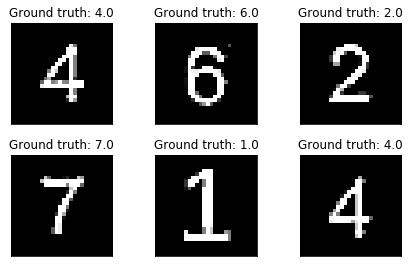

In [286]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# Model

In [284]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [296]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i+len(train_loader.dataset) for i in range(n_epochs+1)]

In [297]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [298]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [299]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [300]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        target = target.long()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [301]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            target = target.long()
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct /len(test_loader.dataset)))

In [302]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\Billi\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 11.4421, Accuracy: 496/17102 (2%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 23.562696
Train Epoch: 1 [100/50000 (0%)]	Loss: 2.331877
Train Epoch: 1 [200/50000 (0%)]	Loss: 2.362224
Train Epoch: 1 [300/50000 (1%)]	Loss: 2.362749
Train Epoch: 1 [400/50000 (1%)]	Loss: 2.310425
Train Epoch: 1 [500/50000 (1%)]	Loss: 1.919306
Train Epoch: 1 [600/50000 (1%)]	Loss: 2.293943
Train Epoch: 1 [700/50000 (1%)]	Loss: 1.671623
Train Epoch: 1 [800/50000 (2%)]	Loss: 1.958878
Train Epoch: 1 [900/50000 (2%)]	Loss: 1.874290
Train Epoch: 1 [1000/50000 (2%)]	Loss: 1.633255
Train Epoch: 1 [1100/50000 (2%)]	Loss: 1.626904
Train Epoch: 1 [1200/50000 (2%)]	Loss: 1.557029
Train Epoch: 1 [1300/50000 (3%)]	Loss: 1.458088
Train Epoch: 1 [1400/50000 (3%)]	Loss: 1.048820
Train Epoch: 1 [1500/50000 (3%)]	Loss: 1.317683
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.038219
Train Epoch: 1 [1700/50000 (3%)]	Loss: 0.829024
Train Epoch: 1 [1800/50000 (4%)]	Loss: 0.956269
Train Epoch: 1 [1900/50000 (4%)]	Loss: 0.7

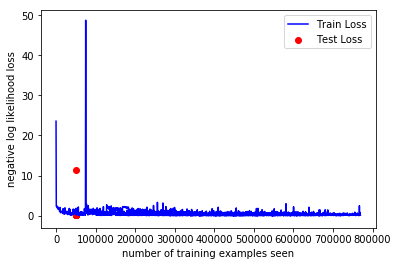

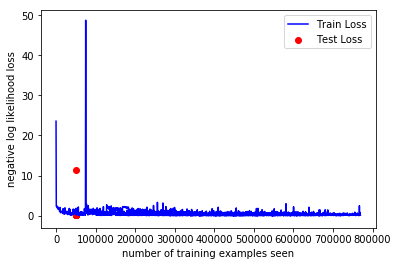

In [303]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig